## This notebook focuses on developing character prediction model using multi layer perceptron.This notebook is based on Andrej Karpathey's building makemore:part 2

In [1]:
import torch
import torch.nn.functional as F # type: ignore
import matplotlib.pyplot as plt

In [2]:
words=open('names.txt','r').read().splitlines()

In [3]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
char=sorted(set(''.join(words))) 
stoi={s:(i+1) for i,s in enumerate(char)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [6]:
block_size=3
x,y=[],[]
for w in words:
    context=[0]*block_size
    # print(w)
    for ch in w+'.':
        ix=stoi[ch]
        x.append(context)
        y.append(ix)
        # print(''.join(itos[i] for i in context),'----->',itos[ix])
        context=context[1:]+[ix]

        
xs=torch.tensor(x)
ys=torch.tensor(y)
xs.shape[0]

228146

In [7]:
def build_dataset(words):
    block_size=3
    x,y=[],[]
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            x.append(context)
            y.append(ix)
            context=context[1:]+[ix]
    xs=torch.tensor(x)    
    ys=torch.tensor(y)
    return xs,ys

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

x_train,y_train=build_dataset(words[:n1])
x_dev,y_dev=build_dataset(words[n1:n2])
x_test,y_test=build_dataset(words[n2:])

In [8]:
print(x_train.shape,y_train.shape)
print(x_dev.shape,y_dev.shape)
print(x_test.shape,y_test.shape)
x_train.shape[0]+x_dev.shape[0]+x_test.shape[0]

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


228146

# Dataset x_train visualization

In [9]:
print('x_train  label')
for j in range(len(x)):
    print(''.join(itos[i] for i in x[j]),end='       ')
    print(itos[y[j]])
    if j>5:
        break

x_train  label
...       e
..e       m
.em       m
emm       a
mma       .
...       o
..o       l


In [104]:
xs.shape,xs.dtype,ys.shape,ys.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

# This portion is just for some extra info , you can just skip to next section to directly see the embedding

there is two way to access the emebedding
and in this case embedding is done in 2 dimensional space


In [10]:
c=torch.randn(27,2)

In [11]:
c[5]

tensor([-0.9197,  0.2046])

In [12]:
F.one_hot(torch.tensor(5),num_classes=27).float()@c

tensor([-0.9197,  0.2046])

Lets just stick with 1st type of accessing the embedding

In [13]:
xs.shape

torch.Size([228146, 3])

In [14]:
c[[5,6,7]]

tensor([[-0.9197,  0.2046],
        [ 0.3370,  0.2455],
        [ 1.9464,  0.5212]])

In [15]:
c[torch.tensor([5,6,7])]

tensor([[-0.9197,  0.2046],
        [ 0.3370,  0.2455],
        [ 1.9464,  0.5212]])

In [16]:
c[torch.tensor([5,6,7,7,7])]

tensor([[-0.9197,  0.2046],
        [ 0.3370,  0.2455],
        [ 1.9464,  0.5212],
        [ 1.9464,  0.5212],
        [ 1.9464,  0.5212]])

In [18]:
c[xs].shape

torch.Size([228146, 3, 2])

In [19]:
c[1]

tensor([0.1829, 0.3860])

In [20]:
xs[13,2]

tensor(1)

In [21]:
c[xs[13,2]]

tensor([0.1829, 0.3860])

# embedding

In [131]:
emb=c[xs]
emb.shape

torch.Size([32, 3, 2])

In [132]:
w=torch.randn(6,100)
bias=torch.randn(100)

In [133]:
emb@w+bias

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [134]:
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape

torch.Size([32, 6])

the above method is not scalabel as if context window increases no of emb and corresponding complecity increases so

In [135]:
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([32, 6])

Generally pytorch stores tensor as sequential array or one dimensional array, hence we can manipulate the tensors directly using views
a.view() and yes this is much more efficient than other 2 beacause there is no other way to manipulate tensors to create new squeezed tensor of [32,6] using using other memory space too. Hence using .view is much more recommeded in case of space complexity

In [136]:
a=torch.arange(16)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [137]:
a.view(4,4)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])

# summarizing a bit

In [138]:
emb=c[xs]
w=torch.randn(6,100)    #weights
b=torch.randn(100)   #bias
h=torch.tanh(emb.view(-1,6)@w+b)

In [139]:
h.shape

torch.Size([32, 100])

In [140]:
w1=torch.randn(100,27)
b1=torch.randn(27)
logits=h@w1+b1

In [141]:
counts=logits.exp()
prob=counts/counts.sum(1,keepdim=True)
loss=-prob[torch.arange(32),ys].log().mean()
loss

tensor(17.8021)

In [142]:
F.cross_entropy(logits,ys)

tensor(17.8021)

Here we can see both cross_entropy and negative log likelihood is same but the case is that we should always use F.cross_entropy insted of custom made loss function.Some of the reasons are:
1)It make forward pass and backward pass easy
2)all the mathematical operations are clustered and are calculated with less space complexity
3)another reason is shown in code

In [143]:
logits=torch.tensor([-100,2,4,100])
counts=logits.exp()
prob=counts/counts.sum()
prob

tensor([0., 0., 0., nan])

In [144]:
counts

tensor([3.7835e-44, 7.3891e+00, 5.4598e+01,        inf])

what happend here is whenever x approaches -ve infinity .exp() tends to one but if logits is very high value then e^logits will be very high excedding dynamic range of float hence prob is nan(This can be seen as inf in o/p)


In [145]:
logits=torch.tensor([-5,2,4,5])
counts=logits.exp()
prob=counts/counts.sum()
prob

tensor([3.2023e-05, 3.5118e-02, 2.5949e-01, 7.0536e-01])

In [146]:
logits

tensor([-5,  2,  4,  5])

In [147]:
logits=torch.tensor([-5,2,4,5])-5
counts=logits.exp()
prob=counts/counts.sum()
prob

tensor([3.2023e-05, 3.5118e-02, 2.5949e-01, 7.0536e-01])

# on adding and subtracting any number from logits wont change the probability 

here's how:

in 1st case 

logits=[-5,  2,  4,  5]

logits[0]=-5

prob1=(e^-5)/((e^-5)+(e^2)+(e^4)+(e^5))

in 2nd case

logits=[-10,  -3,  -1,   0]

logits[0]=-10=-5-5

prob2=(e^-10)/((e^-10)+(e^-3)+(e^-1)+(e^0))

it can be simplified as

    =(e^(-5-5))/((e^(-5-5))+(e^-(2-5))+(e^(4-5))+(e^(5-5)))
    
    =(e^(-5)*e^(-5))/((e^-5)*e^(-5)+(e^2)*e^(-5)+(e^4)*e^(-5)+(e^5)*e^(-5))
    
    =(e^(-5)*e^(-5))/e^(-5)*((e^-5)+(e^2)+(e^4)+(e^5))
    
    =(e^-5)/((e^-5)+(e^2)+(e^4)+(e^5))
    
hence prob1=prob2

In this way ,we can solve the problem of large logits but F.cross_entropy automatically finds max among tensors and subtracts from the given logits hence solving the problem

so is another reason to use in built loss function rather than defining our custom log likihood(negative)

In [148]:
## summary

In [567]:
# dataset
x_train.shape,y_train.shape

(torch.Size([182441, 3]), torch.Size([182441]))

In [612]:

g=torch.Generator().manual_seed(2146483147)
c=torch.randn(27,10,generator=g)
emb=c[xs]
w1=torch.randn(30,200,generator=g)
b1=torch.randn(200,generator=g)
w2=torch.randn(200,27,generator=g)*0.01
b2=torch.randn(27,generator=g)*0
parameters=[c,w1,b1,w2,b2]

In [613]:
sum(p.nelement() for p in parameters)

11897

In [614]:
for p in parameters:
    p.requires_grad=True

In [615]:
lre=torch.linspace(-3,0,1000)
lrs=10**lre

In [414]:
lri,lossi=[],[]
for i in range(1000):
    #creating batch
    ix=torch.randint(0,xs.shape[0],(32,))
    #forward pass
    
    emb=c[xs[ix]]
    h1=torch.tanh(emb.view(-1,30)@w1+b1)
    logits=h1@w2+b2
    loss=F.cross_entropy(logits,ys[ix])
    # print(loss.item())
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    lr=lrs[i]
    for p in parameters:
        p.data+=-lr*p.grad
    lossi.append(loss.item())
    lri.append(lre[i])
# print(loss.item())


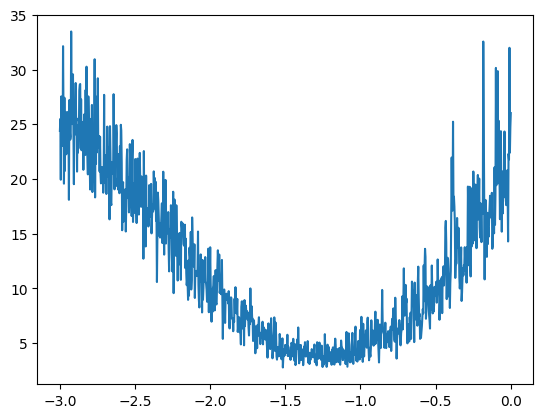

In [415]:

plt.plot(lri,lossi)


here we can see that when lre is in range of -1 to -0.5 loss is min
hence lr should lie within 0.1 to 0.31622

In [571]:
lri,lossi,stepi=[],[],[]


In [584]:

for i in range(50000):
    
    #creating batch
    ix=torch.randint(0,x_train.shape[0],(32,))
    
    #forward pass
    emb=c[x_train[ix]]
    h1=torch.tanh(emb.view(-1,30)@w1+b1)
    logits=h1@w2+b2
    loss=F.cross_entropy(logits,y_train[ix])
    # print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    # lr=lrs[i]
    lr=0.01
    for p in parameters:
        p.data+=-lr*p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())
    # lri.append(lre[i])
# print(loss.item())


In [585]:
emb=c[x_train]
h=torch.tanh(emb.view(-1,30)@w1+b1)
logits=h@w2+b2
loss=F.cross_entropy(logits,y_train)
print(f'{loss}')


2.102555990219116


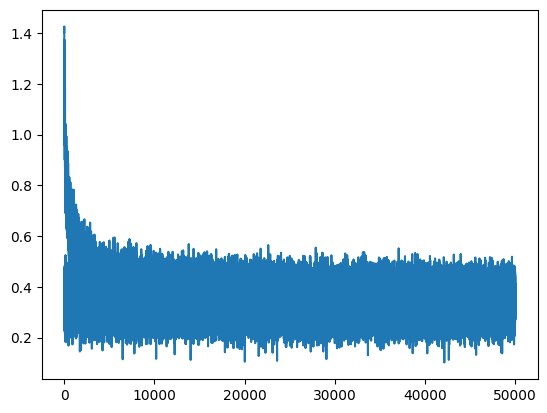

In [586]:
plt.plot(stepi,lossi)


In [587]:
emb=c[x_dev]
h=torch.tanh(emb.view(-1,30)@w1+b1)
logits=h@w2+b2
loss=F.cross_entropy(logits,y_dev)
print(f'{loss}')


2.1465964317321777


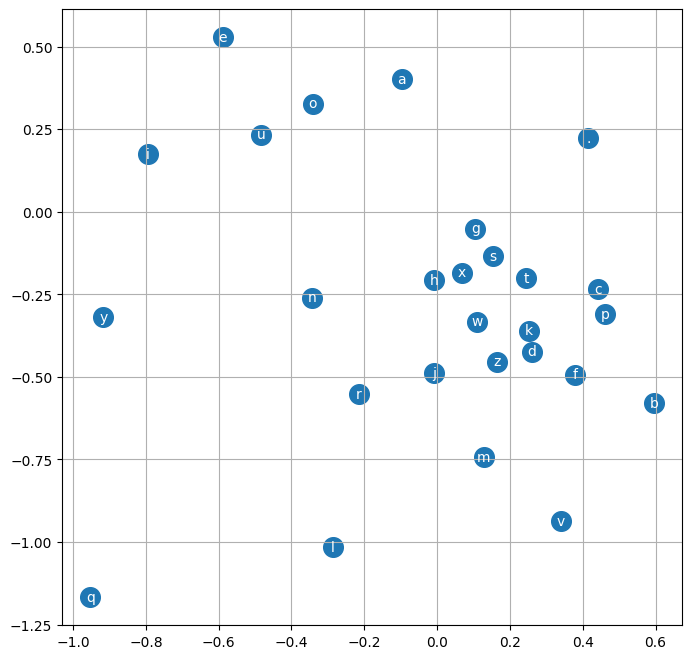

In [496]:
plt.figure(figsize=(8,8))
plt.scatter(c[:,0].data,c[:,1].data,s=200)
for i in range(c.shape[0]):
    plt.text(c[i,0],c[i,1],itos[i],ha='center',va='center',color='white')
plt.grid('minor')

# sampling 


In [602]:
g=torch.Generator().manual_seed(2146483147)
block_size=3
for _ in range(20):
    out=[]
    context=[0]*block_size
    while True:
        emb=c[torch.tensor(context)]
        h1=torch.tanh(emb.view(1,-1)@w1+b1)
        logits=h1@w2+b2
        prob=F.softmax(logits,dim=1)
        ix=torch.multinomial(prob,num_samples=1,replacement=True,generator=g).item()
        out.append(itos[ix])
        if ix==0:
            break
        context=context[1:]+[ix]
    print(''.join(out))

amelle.
nahia.
kalia.
zrothsmana.
eliugh.
wei.
gesten.
sancheshvanna.
maefin.
gord.
kinziya.
kyan.
admir.
dana.
raia.
neila.
ren.
jadyz.
nerynleilar.
cabakasiah.


In [603]:
block_size=3
x,y=[],[]
for w in words[:5]:
    context=[0]*block_size
    # print(w)
    for ch in w+'.':
        ix=stoi[ch]
        x.append(context)
        y.append(ix)
        # print(''.join(itos[i] for i in context),'----->',itos[ix])
        context=context[1:]+[ix]

        
xs=torch.tensor(x)
ys=torch.tensor(y)
xs.shape[0]

32

In [695]:

for i in range(500):
    
    #creating batch
    # ix=torch.randint(0,x_train.shape[0],(32,))
    
    #forward pass
    emb=c[xs]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat@w1+b1
    h1=torch.tanh(hpreact)
    # h1=torch.tanh(emb.view(-1,30)@w1+b1)
    logits=h1@w2+b2
    
    loss=F.cross_entropy(logits,ys)
    # print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    # lr=lrs[i]
    lr=0.01
    for p in parameters:
        p.data+=-lr*p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())
    # lri.append(lre[i])
    # break
print(loss.item())


0.2515602111816406


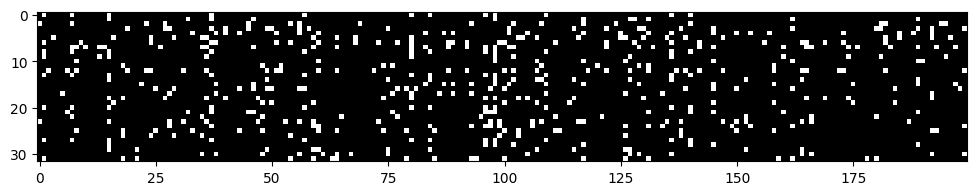

In [696]:
plt.figure(figsize=(12,6))
plt.imshow(h1.abs()==1,cmap='grey')

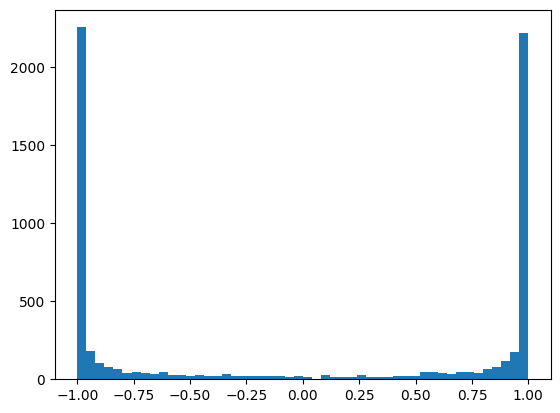

In [692]:
plt.hist(h1.view(-1).tolist(),bins=50);